In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('./data/quantitative/fin_bank'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
data = pd.read_csv("C:/Users/haloi/Downloads/Forecasting-Stock-Perfomance-using-Sentiment-Analysis-ARIMAX-RNN-and-LSTM-main/Forecasting-Stock-Perfomance-using-Sentiment-Analysis-ARIMAX-RNN-and-LSTM-main/data/quantitative/fin_bank/USB.csv")

In [3]:
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,40.671680,54.029999,54.340000,53.790001,54.049999,5367700
1,2018-01-03,41.070641,54.560001,54.770000,53.950001,54.000000,5043800
2,2018-01-04,41.386803,54.980000,55.520000,54.599998,54.689999,7583600
3,2018-01-05,41.642738,55.320000,55.500000,54.950001,55.430000,6863200
4,2018-01-08,41.702965,55.400002,55.529999,55.139999,55.169998,6817400


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1827 non-null   object 
 1   Adj Close  1827 non-null   float64
 2   Close      1827 non-null   float64
 3   High       1827 non-null   float64
 4   Low        1827 non-null   float64
 5   Open       1827 non-null   float64
 6   Volume     1827 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 100.0+ KB


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Set style for plots
plt.style.use('dark_background')

# Color palette for visualizations
colors = {
    'train': '#2ecc71',      # green
    'validation': '#3498db', # blue
    'rnn_pred': '#e74c3c',   # red
    'lstm_pred': '#9b59b6',  # purple
    'grid': '#333333',       # dark gray
    'text': '#ffffff'        # white
}

# Create directories for model storage
os.makedirs('./model/USB', exist_ok=True)

In [7]:
# Load and prepare data
def prepare_data(filepath, split_ratio=0.7, time_step=50):
    """Load, split and prepare data for training"""
    data = pd.read_csv(filepath)
    
    # Calculate split points
    length_data = len(data)
    length_train = round(length_data * split_ratio)
    
    # Split data into training and validation sets
    train_data = data[:length_train][['Date', 'Open']]
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    
    validation_data = data[length_train:][['Date', 'Open']]
    validation_data['Date'] = pd.to_datetime(validation_data['Date'])
    
    # Scale training data
    dataset_train = train_data.Open.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_train_scaled = scaler.fit_transform(dataset_train)
    
    # Create sequences for training
    X_train, y_train = [], []
    for i in range(time_step, len(dataset_train_scaled)):
        X_train.append(dataset_train_scaled[i-time_step:i, 0])
        y_train.append(dataset_train_scaled[i, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    
    # Scale and prepare validation data
    dataset_validation = validation_data.Open.values.reshape(-1, 1)
    scaled_dataset_validation = scaler.transform(dataset_validation)
    
    X_test, y_test = [], []
    for i in range(time_step, len(scaled_dataset_validation)):
        X_test.append(scaled_dataset_validation[i-time_step:i, 0])
        y_test.append(scaled_dataset_validation[i, 0])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (-1, 1))
    
    print(f"Data prepared successfully:")
    print(f"• X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"• X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return data, train_data, validation_data, X_train, y_train, X_test, y_test, scaler


In [8]:
# Visualize data distribution
def visualize_data(train_data, validation_data, dataset_train_scaled, time_step):
    """Create a visualization of the original and scaled data"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # US Bancorp Stock Price Over Time
    axes[0].plot(train_data.Date, train_data.Open, 
             label="Training Data", color=colors['train'], linewidth=2)
    axes[0].plot(validation_data.Date, validation_data.Open, 
             label="Validation Data", color=colors['validation'], linewidth=2)
    
    # Format the plot
    axes[0].set_title('US Bancorp (USB) Stock Price History', fontsize=16, color=colors['text'])
    axes[0].set_xlabel('Date', fontsize=12, color=colors['text'])
    axes[0].set_ylabel('Price ($)', fontsize=12, color=colors['text'])
    axes[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[0].legend()
    
    # Show data distributions
    axes[1].plot(dataset_train_scaled, color=colors['train'], linewidth=1.5, label='Scaled Training Data')
    axes[1].set_title(f'Normalized Training Data (Time Step: {time_step} days)', fontsize=14, color=colors['text'])
    axes[1].set_xlabel('Days', fontsize=12, color=colors['text'])
    axes[1].set_ylabel('Normalized Price', fontsize=12, color=colors['text'])
    axes[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('./model/USB/data_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
# Build and train SimpleRNN model
def build_and_train_rnn(X_train, y_train, X_test, y_test):
    """Build and train a SimpleRNN model"""
    model = Sequential([
        SimpleRNN(50, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        SimpleRNN(50, activation="tanh", return_sequences=True),
        Dropout(0.2),
        SimpleRNN(50, activation="tanh", return_sequences=True),
        Dropout(0.2),
        SimpleRNN(50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
    model.summary()
    
    # Callbacks
    checkpoint = ModelCheckpoint('./model/USB/rnn_best.keras', monitor='val_loss', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train, 
        epochs=50, batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    # Save final model
    model.save('./model/USB/SimpleRNN_model.keras')
    print("SimpleRNN model saved to ./model/USB/SimpleRNN_model.keras")
    
    return model, history

In [10]:
# Build and train LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test):
    """Build and train an LSTM model"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(64, return_sequences=False),
        Dense(32),
        Dense(1)
    ])
    
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
    model.summary()
    
    # Callbacks
    checkpoint = ModelCheckpoint('./model/USB/lstm_best.keras', monitor='val_loss', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train, 
        epochs=50, batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    # Save final model
    model.save('./model/USB/LSTM_model.keras')
    print("LSTM model saved to ./model/USB/LSTM_model.keras")
    
    return model, history

In [11]:
# Visualize training results
def plot_training_history(rnn_history, lstm_history):
    """Plot training metrics for both models"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # RNN Loss
    axes[0, 0].plot(rnn_history.history['loss'], color=colors['train'], label='Train Loss')
    axes[0, 0].plot(rnn_history.history['val_loss'], color=colors['validation'], label='Validation Loss')
    axes[0, 0].set_title('SimpleRNN Model - Loss', fontsize=14)
    axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0, 0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[0, 0].legend()
    
    # RNN Accuracy
    axes[0, 1].plot(rnn_history.history['accuracy'], color=colors['train'], label='Train Accuracy')
    axes[0, 1].plot(rnn_history.history['val_accuracy'], color=colors['validation'], label='Validation Accuracy')
    axes[0, 1].set_title('SimpleRNN Model - Accuracy', fontsize=14)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[0, 1].legend()
    
    # LSTM Loss
    axes[1, 0].plot(lstm_history.history['loss'], color=colors['train'], label='Train Loss')
    axes[1, 0].plot(lstm_history.history['val_loss'], color=colors['validation'], label='Validation Loss')
    axes[1, 0].set_title('LSTM Model - Loss', fontsize=14)
    axes[1, 0].set_xlabel('Epochs', fontsize=12)
    axes[1, 0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[1, 0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[1, 0].legend()
    
    # LSTM Accuracy
    axes[1, 1].plot(lstm_history.history['accuracy'], color=colors['train'], label='Train Accuracy')
    axes[1, 1].plot(lstm_history.history['val_accuracy'], color=colors['validation'], label='Validation Accuracy')
    axes[1, 1].set_title('LSTM Model - Accuracy', fontsize=14)
    axes[1, 1].set_xlabel('Epochs', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('./model/USB/training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
# Evaluate models and visualize predictions
def evaluate_and_visualize(rnn_model, lstm_model, X_train, y_train, X_test, y_test, 
                          scaler, train_data, validation_data, time_step):
    """Evaluate models and visualize predictions"""
    # Make predictions
    y_pred_rnn_train = rnn_model.predict(X_train)
    y_pred_rnn_test = rnn_model.predict(X_test)
    y_pred_lstm_train = lstm_model.predict(X_train)
    y_pred_lstm_test = lstm_model.predict(X_test)
    
    # Inverse transform scaled data
    y_train_inv = scaler.inverse_transform(y_train)
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_rnn_train_inv = scaler.inverse_transform(y_pred_rnn_train)
    y_pred_rnn_test_inv = scaler.inverse_transform(y_pred_rnn_test)
    y_pred_lstm_train_inv = scaler.inverse_transform(y_pred_lstm_train)
    y_pred_lstm_test_inv = scaler.inverse_transform(y_pred_lstm_test)
    
    # Calculate metrics
    metrics = {}
    # RNN metrics
    metrics['rnn_train_mse'] = mean_squared_error(y_train_inv, y_pred_rnn_train_inv)
    metrics['rnn_test_mse'] = mean_squared_error(y_test_inv, y_pred_rnn_test_inv)
    metrics['rnn_train_mae'] = mean_absolute_error(y_train_inv, y_pred_rnn_train_inv)
    metrics['rnn_test_mae'] = mean_absolute_error(y_test_inv, y_pred_rnn_test_inv)
    metrics['rnn_train_r2'] = r2_score(y_train_inv, y_pred_rnn_train_inv)
    metrics['rnn_test_r2'] = r2_score(y_test_inv, y_pred_rnn_test_inv)
    
    # LSTM metrics
    metrics['lstm_train_mse'] = mean_squared_error(y_train_inv, y_pred_lstm_train_inv)
    metrics['lstm_test_mse'] = mean_squared_error(y_test_inv, y_pred_lstm_test_inv)
    metrics['lstm_train_mae'] = mean_absolute_error(y_train_inv, y_pred_lstm_train_inv)
    metrics['lstm_test_mae'] = mean_absolute_error(y_test_inv, y_pred_lstm_test_inv)
    metrics['lstm_train_r2'] = r2_score(y_train_inv, y_pred_lstm_train_inv)
    metrics['lstm_test_r2'] = r2_score(y_test_inv, y_pred_lstm_test_inv)
    
    # Print metrics
    print("\n📊 Model Evaluation Metrics:")
    print("\nSimpleRNN Model:")
    print(f"• Training MSE: {metrics['rnn_train_mse']:.2f}, Testing MSE: {metrics['rnn_test_mse']:.2f}")
    print(f"• Training MAE: {metrics['rnn_train_mae']:.2f}, Testing MAE: {metrics['rnn_test_mae']:.2f}")
    print(f"• Training R²: {metrics['rnn_train_r2']:.4f}, Testing R²: {metrics['rnn_test_r2']:.4f}")
    
    print("\nLSTM Model:")
    print(f"• Training MSE: {metrics['lstm_train_mse']:.2f}, Testing MSE: {metrics['lstm_test_mse']:.2f}")
    print(f"• Training MAE: {metrics['lstm_train_mae']:.2f}, Testing MAE: {metrics['lstm_test_mae']:.2f}")
    print(f"• Training R²: {metrics['lstm_train_r2']:.4f}, Testing R²: {metrics['lstm_test_r2']:.4f}")
    
    # Visualize predictions
    train_dates = train_data.Date.iloc[time_step:].reset_index(drop=True)
    test_dates = validation_data.Date.iloc[time_step:].reset_index(drop=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot all predictions
    axes[0].plot(train_data.Date, train_data.Open, label="Training Data", color=colors['train'])
    axes[0].plot(validation_data.Date, validation_data.Open, label="Validation Data", color=colors['validation'])
    axes[0].plot(train_dates, y_pred_rnn_train_inv, label="RNN Training Prediction", color=colors['rnn_pred'], linestyle='-.')
    axes[0].plot(test_dates, y_pred_rnn_test_inv, label="RNN Testing Prediction", color=colors['rnn_pred'], linestyle='--')
    axes[0].plot(train_dates, y_pred_lstm_train_inv, label="LSTM Training Prediction", color=colors['lstm_pred'], linestyle='-.')
    axes[0].plot(test_dates, y_pred_lstm_test_inv, label="LSTM Testing Prediction", color=colors['lstm_pred'], linestyle='--')
    
    axes[0].set_title('US Bancorp (USB) Stock Price - Model Predictions', fontsize=16)
    axes[0].set_ylabel('Price ($)', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[0].legend()
    
    # Zoomed in view of test predictions
    axes[1].plot(test_dates, y_test_inv, label="Actual Test Data", color=colors['validation'], linewidth=2)
    axes[1].plot(test_dates, y_pred_rnn_test_inv, label="RNN Prediction", color=colors['rnn_pred'], linewidth=1.5)
    axes[1].plot(test_dates, y_pred_lstm_test_inv, label="LSTM Prediction", color=colors['lstm_pred'], linewidth=1.5)
    
    axes[1].set_title('Model Predictions - Validation Period (Zoomed)', fontsize=16)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Price ($)', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7, color=colors['grid'])
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('./model/USB/prediction_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Bar chart for metrics comparison
    plt.figure(figsize=(12, 6))
    
    metrics_to_plot = ['MSE', 'MAE', 'R²']
    x = np.arange(len(metrics_to_plot))
    width = 0.2
    
    # Define values for each metric
    rnn_train_values = [metrics['rnn_train_mse'], metrics['rnn_train_mae'], metrics['rnn_train_r2']]
    rnn_test_values = [metrics['rnn_test_mse'], metrics['rnn_test_mae'], metrics['rnn_test_r2']]
    lstm_train_values = [metrics['lstm_train_mse'], metrics['lstm_train_mae'], metrics['lstm_train_r2']]
    lstm_test_values = [metrics['lstm_test_mse'], metrics['lstm_test_mae'], metrics['lstm_test_r2']]
    
    # Create bars
    bar1 = plt.bar(x - 0.3, rnn_train_values, width, label='RNN Train', color=colors['train'])
    bar2 = plt.bar(x - 0.1, rnn_test_values, width, label='RNN Test', color=colors['rnn_pred'])
    bar3 = plt.bar(x + 0.1, lstm_train_values, width, label='LSTM Train', color=colors['validation'])
    bar4 = plt.bar(x + 0.3, lstm_test_values, width, label='LSTM Test', color=colors['lstm_pred'])
    
    # Add numbers on top of bars
    def add_labels(bars, values):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            # Format differently based on the metric (R² values are small)
            if value < 1:  # For R² values
                label = f'{value:.4f}'
            else:  # For MSE and MAE values
                label = f'{value:.2f}'
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*max(rnn_train_values[0], rnn_test_values[0]),
                    label, ha='center', va='bottom', color='white', fontweight='bold', fontsize=9)
    
    # Add labels to all bars
    add_labels(bar1, rnn_train_values)
    add_labels(bar2, rnn_test_values)
    add_labels(bar3, lstm_train_values)
    add_labels(bar4, lstm_test_values)
    
    plt.title('Model Performance Metrics Comparison', fontsize=16)
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7, color=colors['grid'])
    
    plt.tight_layout()
    plt.savefig('./model/USB/metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics

In [13]:
# Make future prediction
def predict_future(rnn_model, lstm_model, data, scaler, time_step=50, days_ahead=1):
    """Make prediction for the next day based on the latest data"""
    # Get last time_step data points
    last_data = data.iloc[-time_step:]['Open'].values.reshape(-1, 1)
    last_data_scaled = scaler.transform(last_data)
    X_input = np.reshape(last_data_scaled, (1, time_step, 1))
    
    # Make predictions
    rnn_pred = rnn_model.predict(X_input)
    lstm_pred = lstm_model.predict(X_input)
    
    # Convert back to original scale
    rnn_pred_price = scaler.inverse_transform(rnn_pred)[0][0]
    lstm_pred_price = scaler.inverse_transform(lstm_pred)[0][0]
    
    # Calculate prediction date
    last_date = pd.to_datetime(data['Date'].iloc[-1])
    next_date = last_date + timedelta(days=days_ahead)
    
    print(f"\n🔮 Predictions for {next_date.strftime('%Y-%m-%d')}:")
    print(f"• SimpleRNN prediction: ${rnn_pred_price:.2f}")
    print(f"• LSTM prediction: ${lstm_pred_price:.2f}")
    
    return {
        'date': next_date,
        'rnn_prediction': rnn_pred_price,
        'lstm_prediction': lstm_pred_price
    }


In [14]:
# Fine-tune models with new data
def fine_tune_models(rnn_model, lstm_model, new_data, time_step=50, epochs=10):
    """Fine-tune existing models with new data"""
    # Prepare new data
    new_values = new_data['Open'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(new_values)
    
    # Create sequences
    X_new, y_new = [], []
    for i in range(time_step, len(scaled_data)):
        X_new.append(scaled_data[i-time_step:i, 0])
        y_new.append(scaled_data[i, 0])
    
    X_new, y_new = np.array(X_new), np.array(y_new)
    X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))
    y_new = np.reshape(y_new, (y_new.shape[0], 1))
    
    print(f"Fine-tuning with new data: {X_new.shape[0]} samples")
    
    # Fine-tune RNN model
    rnn_history = rnn_model.fit(
        X_new, y_new, epochs=epochs, batch_size=32, verbose=1
    )
    
    # Fine-tune LSTM model
    lstm_history = lstm_model.fit(
        X_new, y_new, epochs=epochs, batch_size=32, verbose=1
    )
    
    # Save updated models
    rnn_model.save('./model/USB/SimpleRNN_model_finetuned.h5')
    lstm_model.save('./model/USB/LSTM_model_finetuned.h5')
    print("Fine-tuned models saved to ./model/USB/")
    
    return rnn_model, lstm_model, rnn_history, lstm_history


In [15]:
# Load and prepare data
filepath = "C:/Users/haloi/Downloads/Forecasting-Stock-Perfomance-using-Sentiment-Analysis-ARIMAX-RNN-and-LSTM-main\Forecasting-Stock-Perfomance-using-Sentiment-Analysis-ARIMAX-RNN-and-LSTM-main/data/quantitative/fin_bank/USB.csv"
time_step = 50
data, train_data, validation_data, X_train, y_train, X_test, y_test, scaler = prepare_data(
    filepath, split_ratio=0.7, time_step=time_step
)

Data prepared successfully:
• X_train shape: (1229, 50, 1), y_train shape: (1229, 1)
• X_test shape: (498, 50, 1), y_test shape: (498, 1)


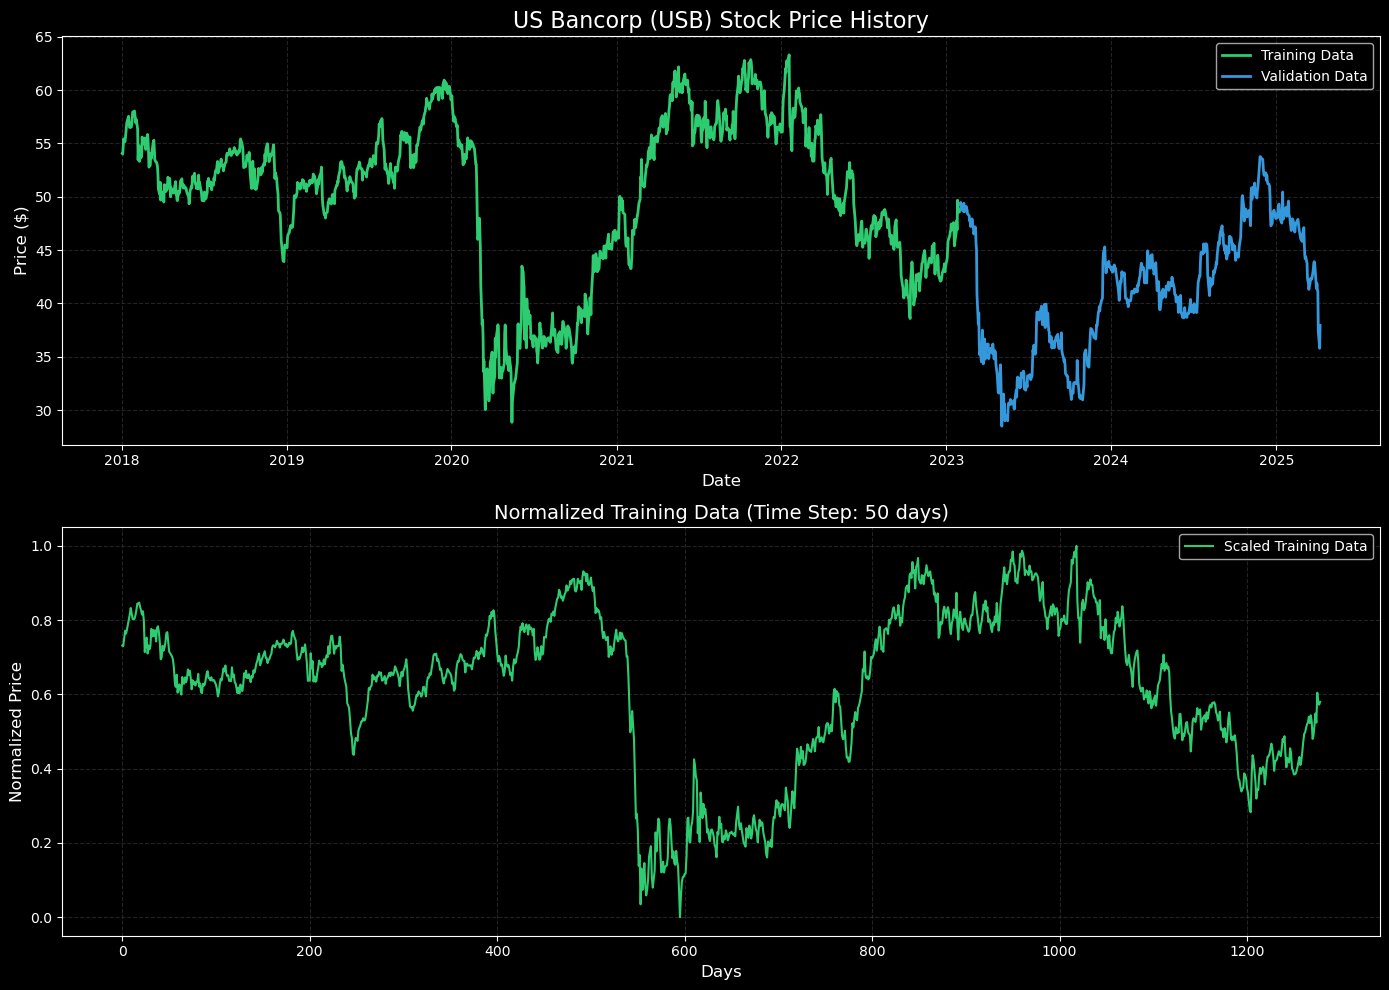

In [16]:
# Visualize the data
visualize_data(train_data, validation_data, scaler.transform(train_data.Open.values.reshape(-1, 1)), time_step)

In [17]:
# Build and train models
rnn_model, rnn_history = build_and_train_rnn(X_train, y_train, X_test, y_test)
lstm_model, lstm_history = build_and_train_lstm(X_train, y_train, X_test, y_test)
  
  # Visualize training history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.0019 - loss: 0.5267 - val_accuracy: 0.0000e+00 - val_loss: 0.0087
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 1.4936e-04 - loss: 0.2773 - val_accuracy: 0.0000e+00 - val_loss: 0.0143
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 1.0406e-04 - loss: 0.2071 - val_accuracy: 0.0000e+00 - val_loss: 0.0064
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.0019 - loss: 0.2046 - val_accuracy: 0.0000e+00 - val_loss: 0.0125
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.0033 - loss: 0.1477 - val_accuracy: 0.0000e+00 - val_loss: 0.0092
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 1.4936e-04 - loss: 0.1206 - val_accuracy: 0.0000e+00 - val_loss: 0.0165
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 7.0897e-04 - loss: 0.0966 - val_accuracy: 0.0000e+00 - val_loss: 0.0134
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 

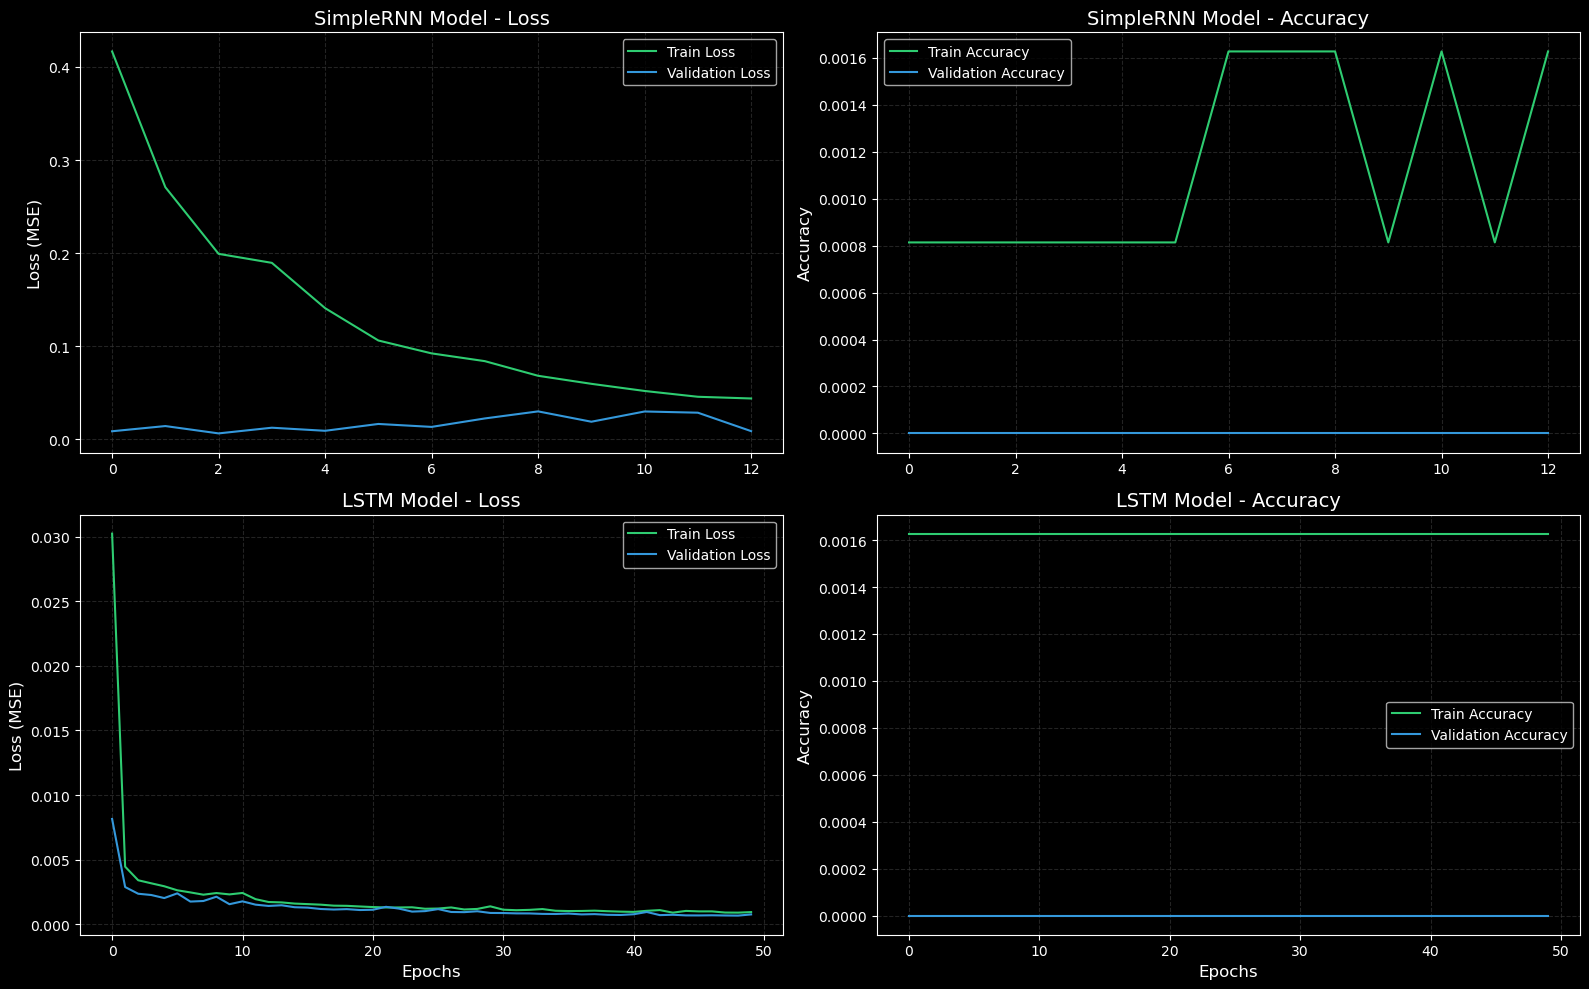

In [18]:
# Visualize training history
plot_training_history(rnn_history, lstm_history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

📊 Model Evaluation Metrics:

SimpleRNN Model:
• Training MSE: 11.37, Testing MSE: 7.57
• Training MAE: 2.61, Testing MAE: 2.18
• Training R²: 0.7887, Testing R²: 0.7759

LSTM Model:
• Training MSE: 0.99, Testing MSE: 0.79
• Training MAE: 0.73, Testing MAE: 0.66
• Training R²: 0.9816, Testing R²: 0.9766


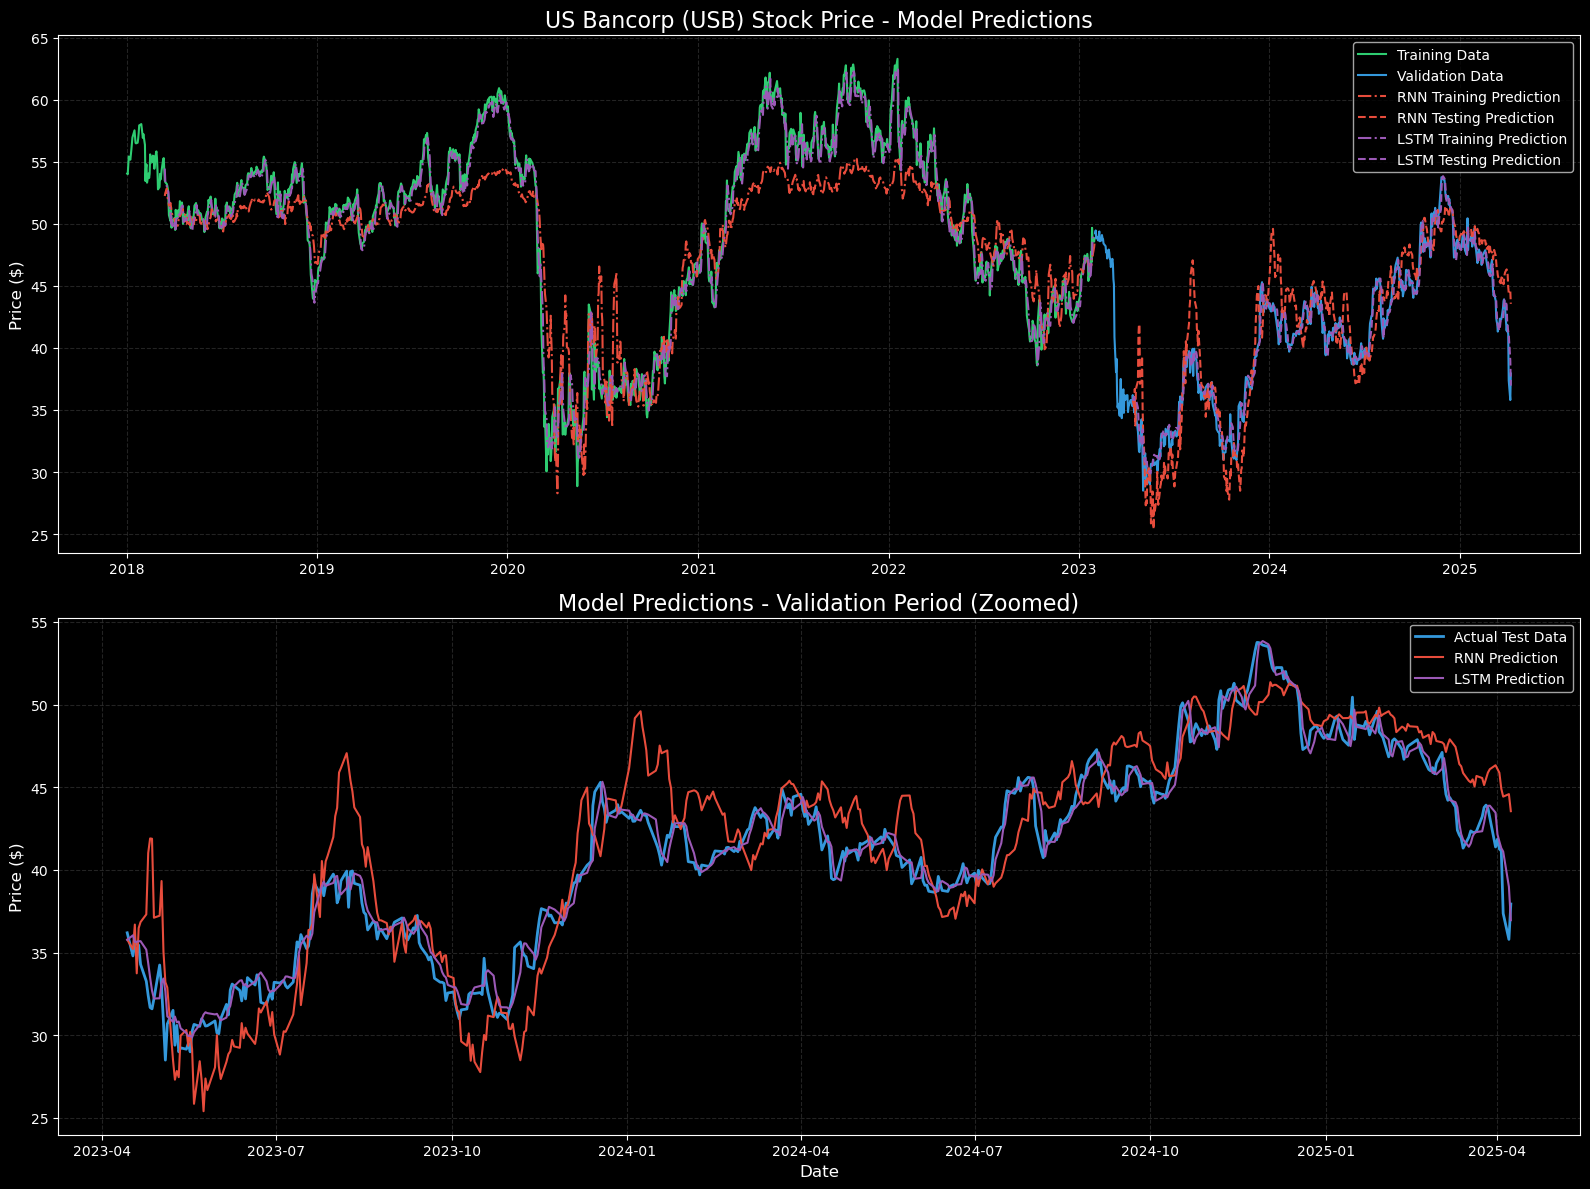

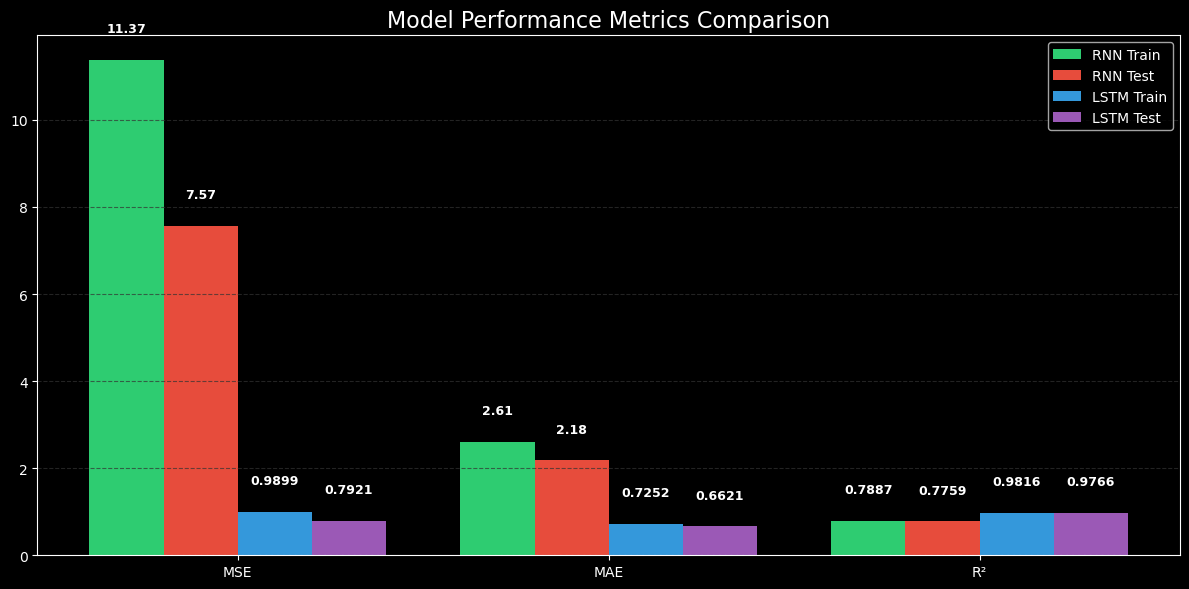

In [19]:
# Evaluate models and visualize predictions
metrics = evaluate_and_visualize(
    rnn_model, lstm_model, X_train, y_train, X_test, y_test,
    scaler, train_data, validation_data, time_step
)

In [20]:
# Make future prediction
future_pred = predict_future(rnn_model, lstm_model, data, scaler)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step

🔮 Predictions for 2025-04-09:
• SimpleRNN prediction: $41.92
• LSTM prediction: $37.05


In [21]:
def predict_multiple_days(rnn_model, lstm_model, data, scaler, time_step=50, days_ahead=30):
    """Predict stock prices for multiple days ahead using both RNN and LSTM models"""
    # Start with the last time_step days from the dataset
    last_sequence = data.iloc[-time_step:]['Open'].values.reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    
    # Store predictions
    predictions = {
        'dates': [],
        'rnn_predictions': [],
        'lstm_predictions': []
    }
    
    last_date = pd.to_datetime(data['Date'].iloc[-1])
    
    # Make sequential predictions
    rnn_sequence = last_sequence_scaled.copy()
    lstm_sequence = last_sequence_scaled.copy()
    
    for i in range(days_ahead):
        # Prepare input for RNN model
        rnn_input = rnn_sequence[-time_step:].reshape(1, time_step, 1)
        
        # Prepare input for LSTM model
        lstm_input = lstm_sequence[-time_step:].reshape(1, time_step, 1)
        
        # Predict next value
        rnn_pred = rnn_model.predict(rnn_input, verbose=0)
        lstm_pred = lstm_model.predict(lstm_input, verbose=0)
        
        # Add to predictions
        pred_date = last_date + timedelta(days=i+1)
        rnn_pred_price = scaler.inverse_transform(rnn_pred)[0][0]
        lstm_pred_price = scaler.inverse_transform(lstm_pred)[0][0]
        
        predictions['dates'].append(pred_date)
        predictions['rnn_predictions'].append(rnn_pred_price)
        predictions['lstm_predictions'].append(lstm_pred_price)
        
        # Update sequences for next prediction
        rnn_sequence = np.append(rnn_sequence, rnn_pred).reshape(-1, 1)
        rnn_sequence = rnn_sequence[1:]
        
        lstm_sequence = np.append(lstm_sequence, lstm_pred).reshape(-1, 1)
        lstm_sequence = lstm_sequence[1:]
    
    # Create a nice visualization of the predictions
    plt.figure(figsize=(16, 8))
    plt.plot(predictions['dates'], predictions['rnn_predictions'], 
             label='RNN Predictions', color='#e74c3c', linewidth=2)
    plt.plot(predictions['dates'], predictions['lstm_predictions'], 
             label='LSTM Predictions', color='#9b59b6', linewidth=2)
    
    # Add the last known price point to connect with historical data
    plt.scatter([last_date], [data['Open'].iloc[-1]], 
                color='#3498db', s=100, label='Last Known Price')
    
    plt.title(f'US Bancorp (USB) Stock Price Predictions for Next {days_ahead} Days', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Format y-axis as currency
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
    
    # Add annotations for beginning and end prices
    plt.annotate(f'${predictions["rnn_predictions"][0]:.2f}', 
                xy=(predictions['dates'][0], predictions['rnn_predictions'][0]),
                xytext=(10, 10), textcoords='offset points',
                color='#e74c3c', fontweight='bold')
    
    plt.annotate(f'${predictions["lstm_predictions"][0]:.2f}', 
                xy=(predictions['dates'][0], predictions['lstm_predictions'][0]),
                xytext=(10, -20), textcoords='offset points',
                color='#9b59b6', fontweight='bold')
    
    plt.annotate(f'${predictions["rnn_predictions"][-1]:.2f}', 
                xy=(predictions['dates'][-1], predictions['rnn_predictions'][-1]),
                xytext=(10, 10), textcoords='offset points',
                color='#e74c3c', fontweight='bold')
    
    plt.annotate(f'${predictions["lstm_predictions"][-1]:.2f}', 
                xy=(predictions['dates'][-1], predictions['lstm_predictions'][-1]),
                xytext=(10, -20), textcoords='offset points',
                color='#9b59b6', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./model/USB/future_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print a summary
    print(f"\n🔮 Predictions for the next {days_ahead} days:")
    print(f"• Starting RNN prediction: ${predictions['rnn_predictions'][0]:.2f}")
    print(f"• Ending RNN prediction (after {days_ahead} days): ${predictions['rnn_predictions'][-1]:.2f}")
    print(f"• Starting LSTM prediction: ${predictions['lstm_predictions'][0]:.2f}")
    print(f"• Ending LSTM prediction (after {days_ahead} days): ${predictions['lstm_predictions'][-1]:.2f}")
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame({
        'Date': predictions['dates'],
        'RNN_Prediction': predictions['rnn_predictions'],
        'LSTM_Prediction': predictions['lstm_predictions']
    })
    
    return results_df

# Example usage:
# future_pred_50 = predict_multiple_days(rnn_model, lstm_model, data, scaler, days_ahead=50)

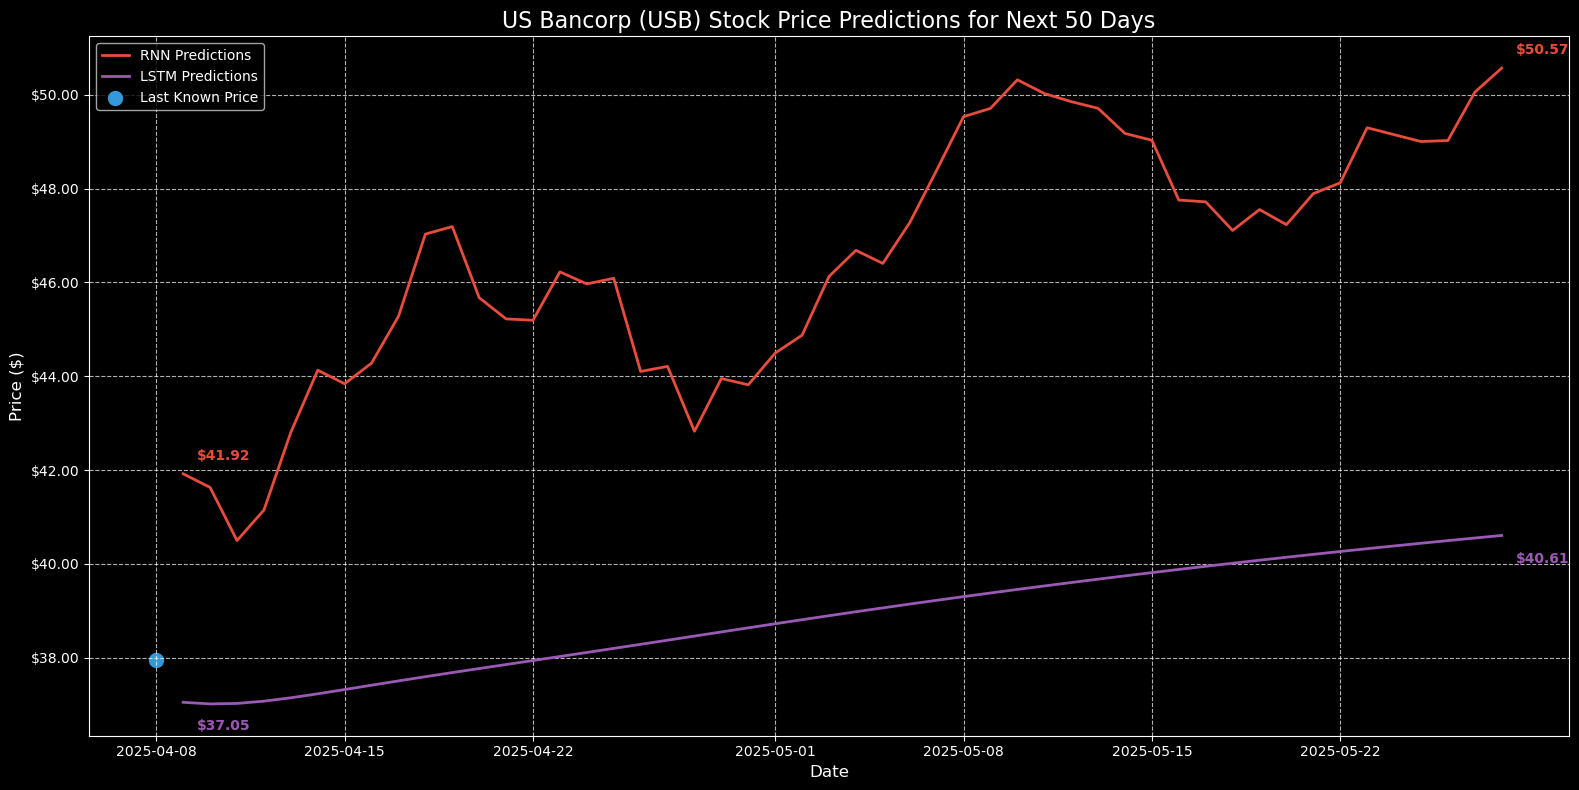


🔮 Predictions for the next 50 days:
• Starting RNN prediction: $41.92
• Ending RNN prediction (after 50 days): $50.57
• Starting LSTM prediction: $37.05
• Ending LSTM prediction (after 50 days): $40.61


In [22]:
# Make predictions for the next 50 days
future_pred_50 = predict_multiple_days(rnn_model, lstm_model, data, scaler, days_ahead=50)

In [23]:
def evaluate_multi_day_predictions(rnn_model, lstm_model, data, scaler, time_step=50, prediction_length=30):
    """
    Evaluate how accurately the models predict multiple days ahead by using historical data.
    
    Parameters:
    -----------
    rnn_model : Keras model
        The trained RNN model
    lstm_model : Keras model
        The trained LSTM model
    data : DataFrame
        The full dataset with 'Date' and 'Open' columns
    scaler : MinMaxScaler
        The scaler used to normalize the data
    time_step : int
        The number of days used as input for prediction
    prediction_length : int
        The number of days to predict ahead
        
    Returns:
    --------
    DataFrame with evaluation metrics
    """
    # We need at least (time_step + prediction_length) data points
    required_points = time_step + prediction_length
    if len(data) < required_points:
        raise ValueError(f"Not enough data points. Need at least {required_points} points.")
    
    # Create evaluation points - we'll test at several points in the dataset
    # We'll skip the training portion to avoid biased results
    train_size = int(0.7 * len(data))  # Assuming 70% of data was used for training
    
    # We'll evaluate at 5 different points in the validation data
    eval_indices = []
    available_range = len(data) - required_points - train_size
    if available_range <= 0:
        # If not enough validation data, we'll just use one point
        eval_indices = [train_size]
    else:
        # Create 5 evenly spaced evaluation points in the validation data
        step = max(1, available_range // 5)
        eval_indices = [train_size + i * step for i in range(min(5, available_range))]
    
    results = []
    
    # For each evaluation point
    for start_idx in eval_indices:
        # Extract actual data for comparison
        actual_data = data.iloc[start_idx + time_step:start_idx + time_step + prediction_length]['Open'].values
        actual_dates = data.iloc[start_idx + time_step:start_idx + time_step + prediction_length]['Date'].values
        
        # Get the sequence to start predictions
        input_sequence = data.iloc[start_idx:start_idx + time_step]['Open'].values.reshape(-1, 1)
        input_sequence_scaled = scaler.transform(input_sequence)
        
        # Make sequential predictions
        rnn_sequence = input_sequence_scaled.copy()
        lstm_sequence = input_sequence_scaled.copy()
        
        rnn_predictions = []
        lstm_predictions = []
        
        for i in range(prediction_length):
            # Prepare inputs
            rnn_input = rnn_sequence.reshape(1, time_step, 1)
            lstm_input = lstm_sequence.reshape(1, time_step, 1)
            
            # Make predictions
            rnn_pred = rnn_model.predict(rnn_input, verbose=0)
            lstm_pred = lstm_model.predict(lstm_input, verbose=0)
            
            # Store predictions
            rnn_pred_price = scaler.inverse_transform(rnn_pred)[0][0]
            lstm_pred_price = scaler.inverse_transform(lstm_pred)[0][0]
            
            rnn_predictions.append(rnn_pred_price)
            lstm_predictions.append(lstm_pred_price)
            
            # Update sequences (remove oldest value, add prediction)
            rnn_sequence = np.append(rnn_sequence[1:], rnn_pred).reshape(-1, 1)
            lstm_sequence = np.append(lstm_sequence[1:], lstm_pred).reshape(-1, 1)
        
        # Calculate metrics
        rnn_mse = mean_squared_error(actual_data, rnn_predictions)
        rnn_mae = mean_absolute_error(actual_data, rnn_predictions)
        rnn_r2 = r2_score(actual_data, rnn_predictions)
        
        lstm_mse = mean_squared_error(actual_data, lstm_predictions)
        lstm_mae = mean_absolute_error(actual_data, lstm_predictions)
        lstm_r2 = r2_score(actual_data, lstm_predictions)
        
        # Calculate directional accuracy (if price movement direction was predicted correctly)
        rnn_direction_correct = 0
        lstm_direction_correct = 0
        
        for i in range(1, prediction_length):
            # Actual direction
            actual_direction = actual_data[i] > actual_data[i-1]
            
            # Predicted directions
            rnn_direction = rnn_predictions[i] > rnn_predictions[i-1]
            lstm_direction = lstm_predictions[i] > lstm_predictions[i-1]
            
            # Count correct directions
            if rnn_direction == actual_direction:
                rnn_direction_correct += 1
            
            if lstm_direction == actual_direction:
                lstm_direction_correct += 1
        
        rnn_direction_accuracy = rnn_direction_correct / (prediction_length - 1) if prediction_length > 1 else 0
        lstm_direction_accuracy = lstm_direction_correct / (prediction_length - 1) if prediction_length > 1 else 0
        
        # Create a visualization
        start_date = pd.to_datetime(data.iloc[start_idx + time_step]['Date'])
        title_date = start_date.strftime('%Y-%m-%d')
        
        plt.figure(figsize=(16, 8))
        plt.plot(actual_dates, actual_data, label='Actual Prices', color='#2ecc71', linewidth=2)
        plt.plot(actual_dates, rnn_predictions, label='RNN Predictions', color='#e74c3c', linewidth=2, alpha=0.7)
        plt.plot(actual_dates, lstm_predictions, label='LSTM Predictions', color='#9b59b6', linewidth=2, alpha=0.7)
        
        plt.title(f'30-Day Prediction Accuracy Starting from {title_date}', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Format y-axis as currency
        plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.2f}'))
        
        plt.tight_layout()
        plt.savefig(f'./model/USB/backtest_{start_idx}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store results
        results.append({
            'start_date': start_date,
            'rnn_mse': rnn_mse,
            'rnn_mae': rnn_mae,
            'rnn_r2': rnn_r2,
            'rnn_direction_accuracy': rnn_direction_accuracy,
            'lstm_mse': lstm_mse,
            'lstm_mae': lstm_mae,
            'lstm_r2': lstm_r2,
            'lstm_direction_accuracy': lstm_direction_accuracy
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate average metrics
    avg_metrics = {
        'RNN MSE': results_df['rnn_mse'].mean(),
        'RNN MAE': results_df['rnn_mae'].mean(),
        'RNN R²': results_df['rnn_r2'].mean(),
        'RNN Direction Accuracy': results_df['rnn_direction_accuracy'].mean(),
        'LSTM MSE': results_df['lstm_mse'].mean(),
        'LSTM MAE': results_df['lstm_mae'].mean(),
        'LSTM R²': results_df['lstm_r2'].mean(),
        'LSTM Direction Accuracy': results_df['lstm_direction_accuracy'].mean()
    }
    
    # Print summary
    print("\n📊 30-Day Prediction Accuracy Evaluation:")
    print("\nSimpleRNN Model:")
    print(f"• Average MSE: {avg_metrics['RNN MSE']:.2f}")
    print(f"• Average MAE: {avg_metrics['RNN MAE']:.2f}")
    print(f"• Average R²: {avg_metrics['RNN R²']:.4f}")
    print(f"• Average Direction Accuracy: {avg_metrics['RNN Direction Accuracy']*100:.2f}%")
    
    print("\nLSTM Model:")
    print(f"• Average MSE: {avg_metrics['LSTM MSE']:.2f}")
    print(f"• Average MAE: {avg_metrics['LSTM MAE']:.2f}")
    print(f"• Average R²: {avg_metrics['LSTM R²']:.4f}")
    print(f"• Average Direction Accuracy: {avg_metrics['LSTM Direction Accuracy']*100:.2f}%")
    
    # Create visualization of averaged metrics
    plt.figure(figsize=(12, 8))
    
    # Set up bar positions
    metrics_names = ['MSE', 'MAE', 'R²', 'Direction Accuracy']
    x = np.arange(len(metrics_names))
    width = 0.35
    
    # Prepare values (scaling R² and Direction Accuracy for better visibility)
    rnn_values = [
        avg_metrics['RNN MSE'],
        avg_metrics['RNN MAE'],
        avg_metrics['RNN R²'] * 100,  # Scale R² by 100
        avg_metrics['RNN Direction Accuracy'] * 100  # Already as percentage
    ]
    
    lstm_values = [
        avg_metrics['LSTM MSE'],
        avg_metrics['LSTM MAE'],
        avg_metrics['LSTM R²'] * 100,  # Scale R² by 100
        avg_metrics['LSTM Direction Accuracy'] * 100  # Already as percentage
    ]
    
    # Create bars
    rnn_bars = plt.bar(x - width/2, rnn_values, width, label='RNN Model', color='#e74c3c')
    lstm_bars = plt.bar(x + width/2, lstm_values, width, label='LSTM Model', color='#9b59b6')
    
    # Add value labels
    def add_labels(bars, values, metrics_idx):
        for i, (bar, value) in enumerate(zip(bars, values)):
            if metrics_idx[i] in ['R²', 'Direction Accuracy']:
                # For percentage metrics
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                # For MSE, MAE
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    add_labels(rnn_bars, rnn_values, metrics_names)
    add_labels(lstm_bars, lstm_values, metrics_names)
    
    plt.ylabel('Value')
    plt.title('30-Day Prediction Performance Metrics Comparison')
    plt.xticks(x, metrics_names)
    plt.legend()
    
    # Add note for scaled metrics
    plt.figtext(0.5, 0.01, "Note: R² and Direction Accuracy values are shown as percentages for better visibility", 
                ha='center', fontsize=9, fontstyle='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig('./model/USB/50day_prediction_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_df



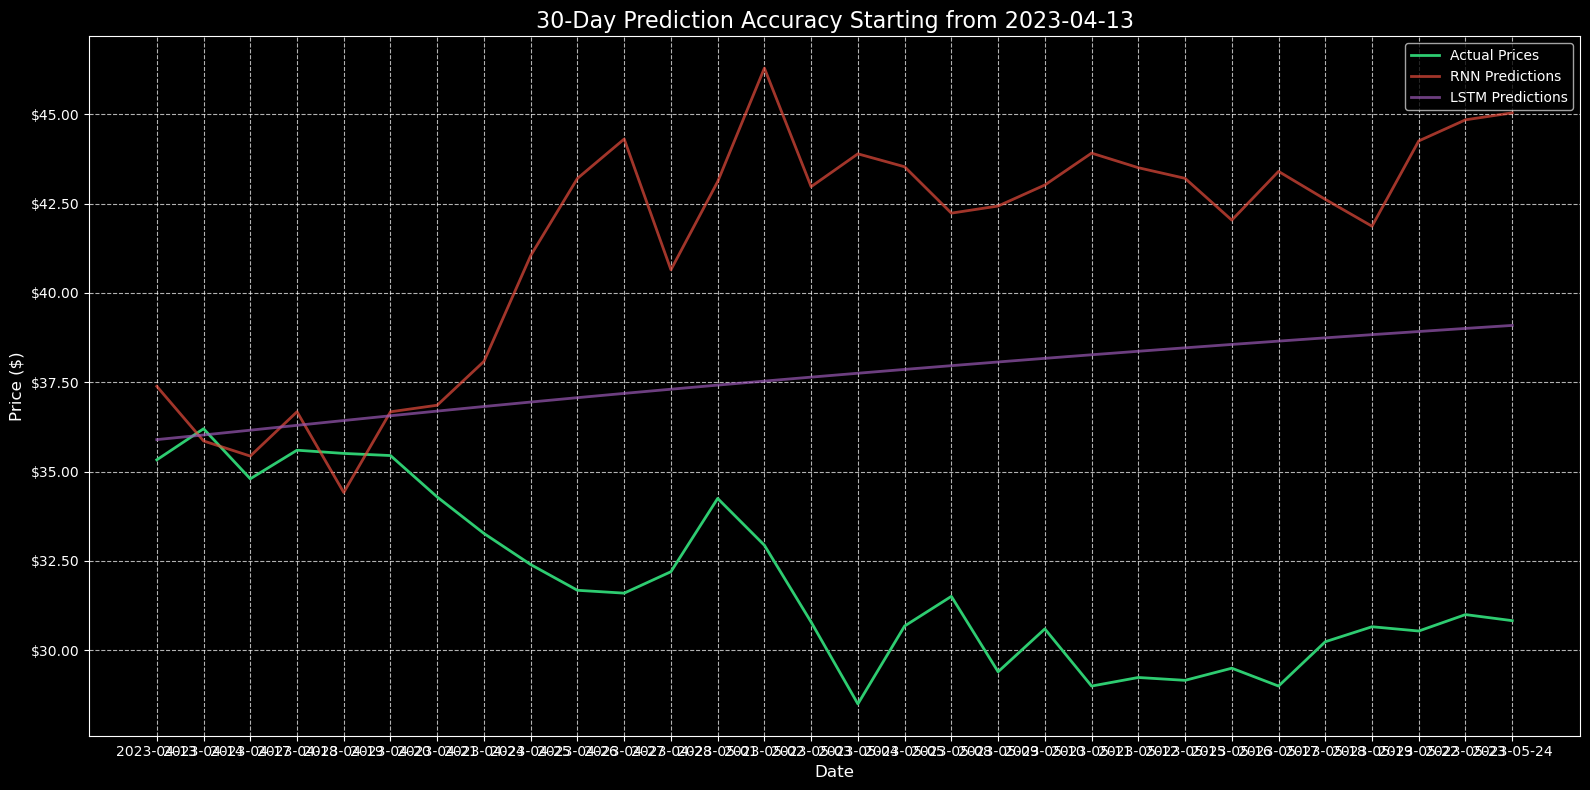

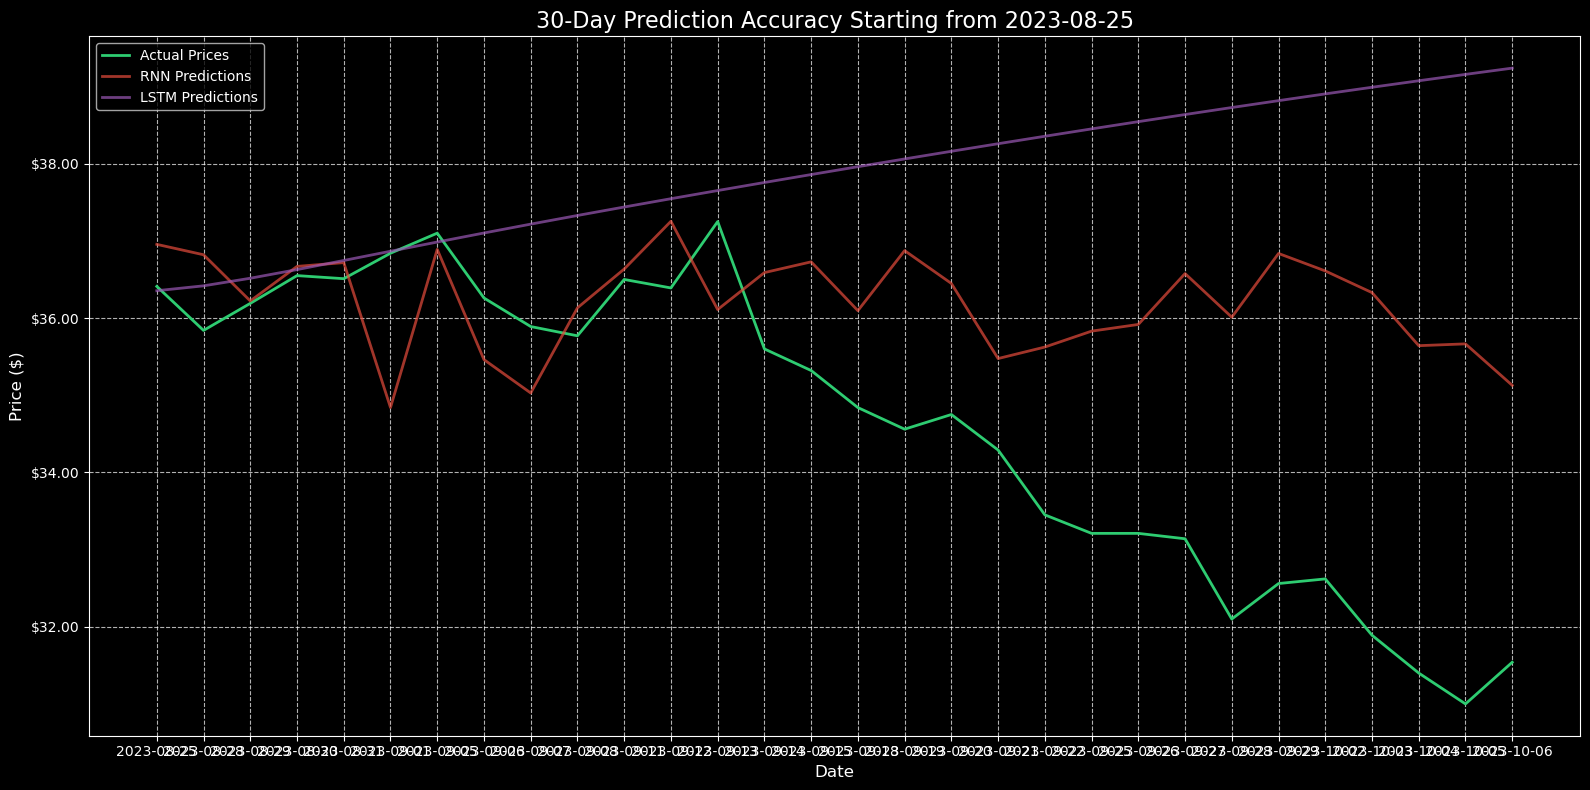

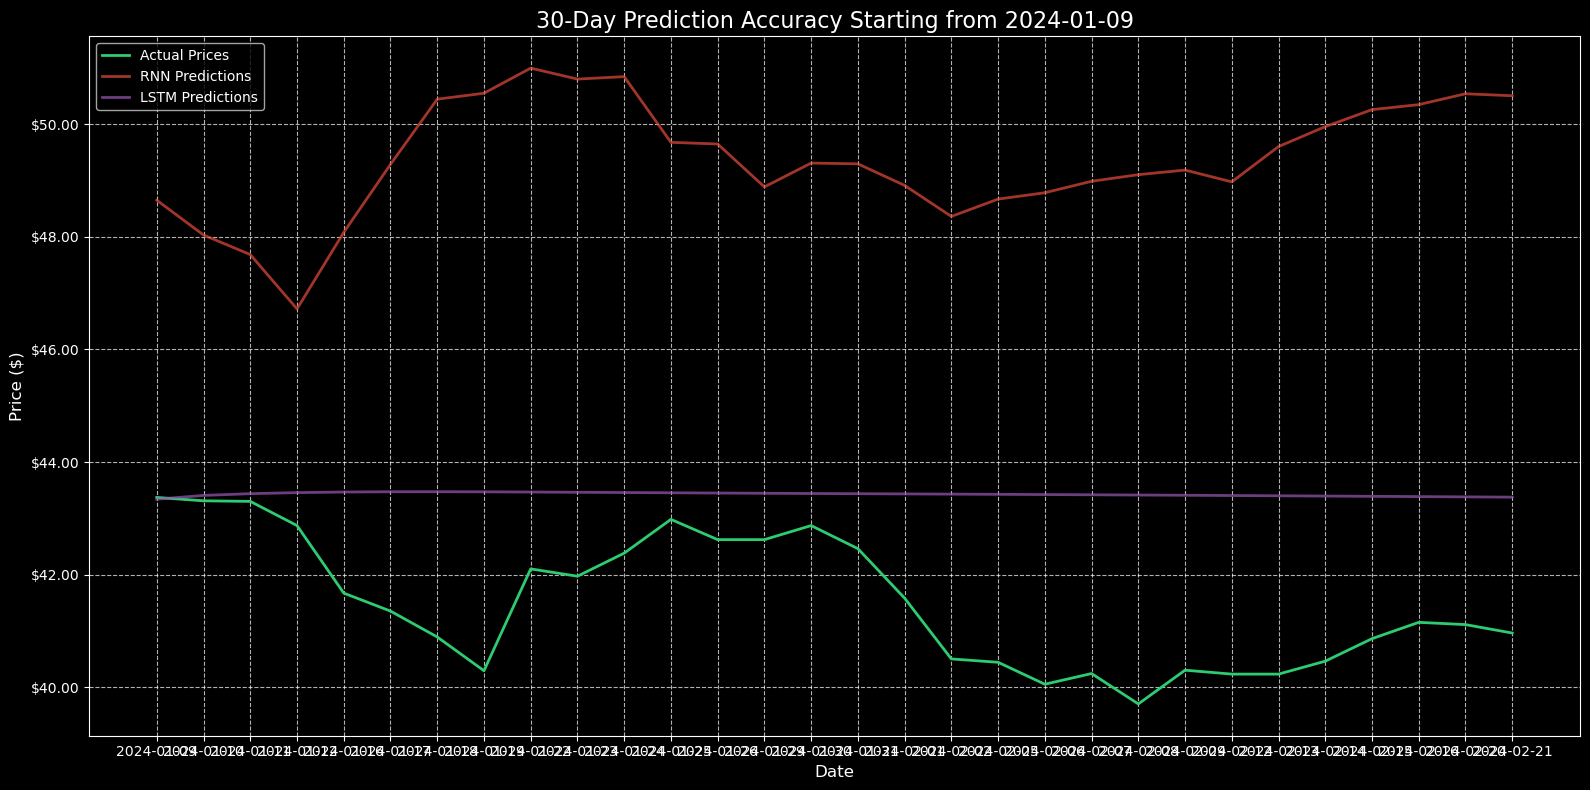

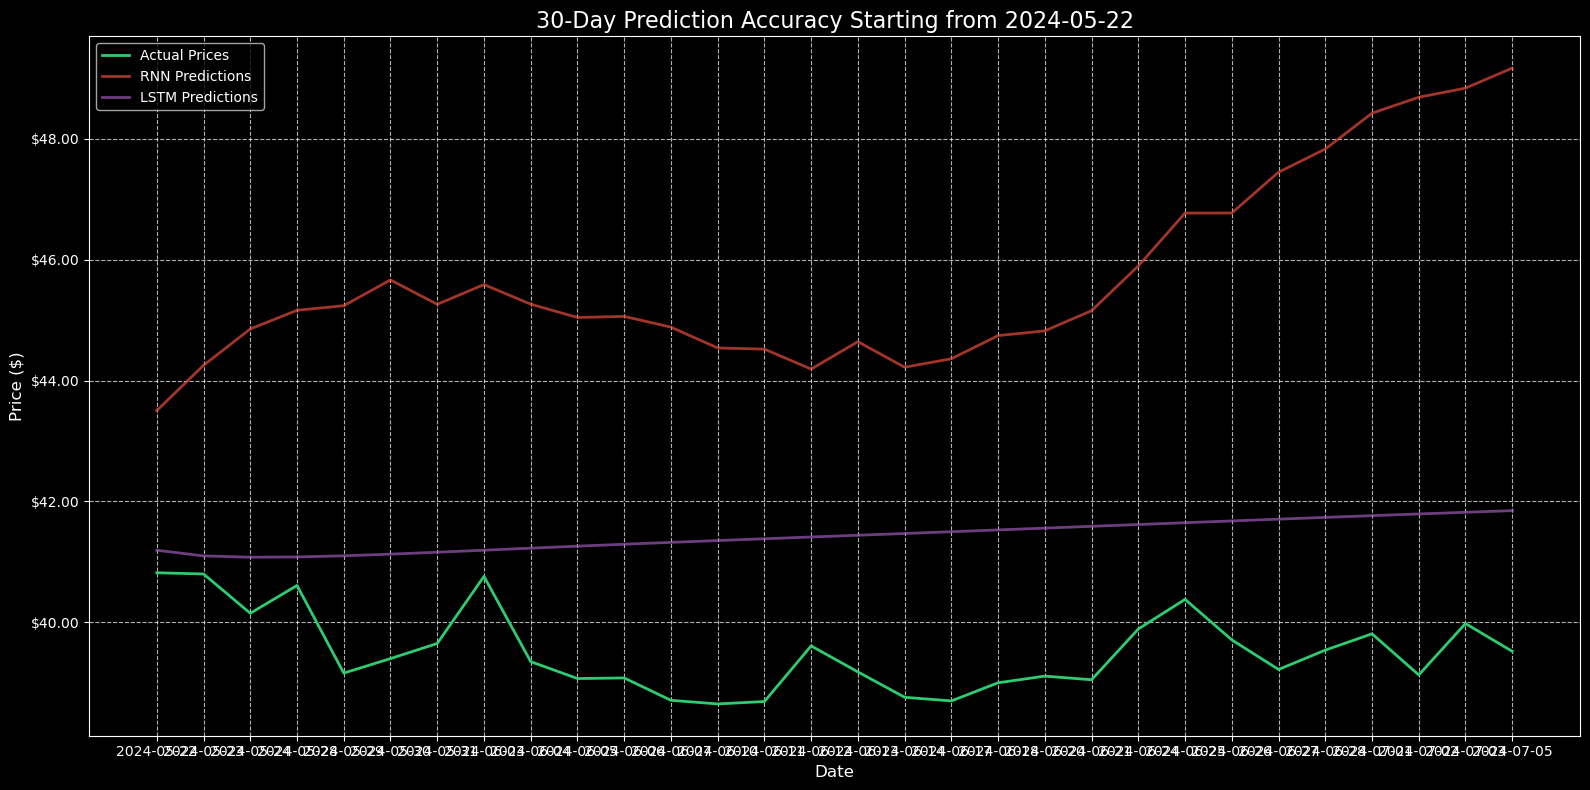

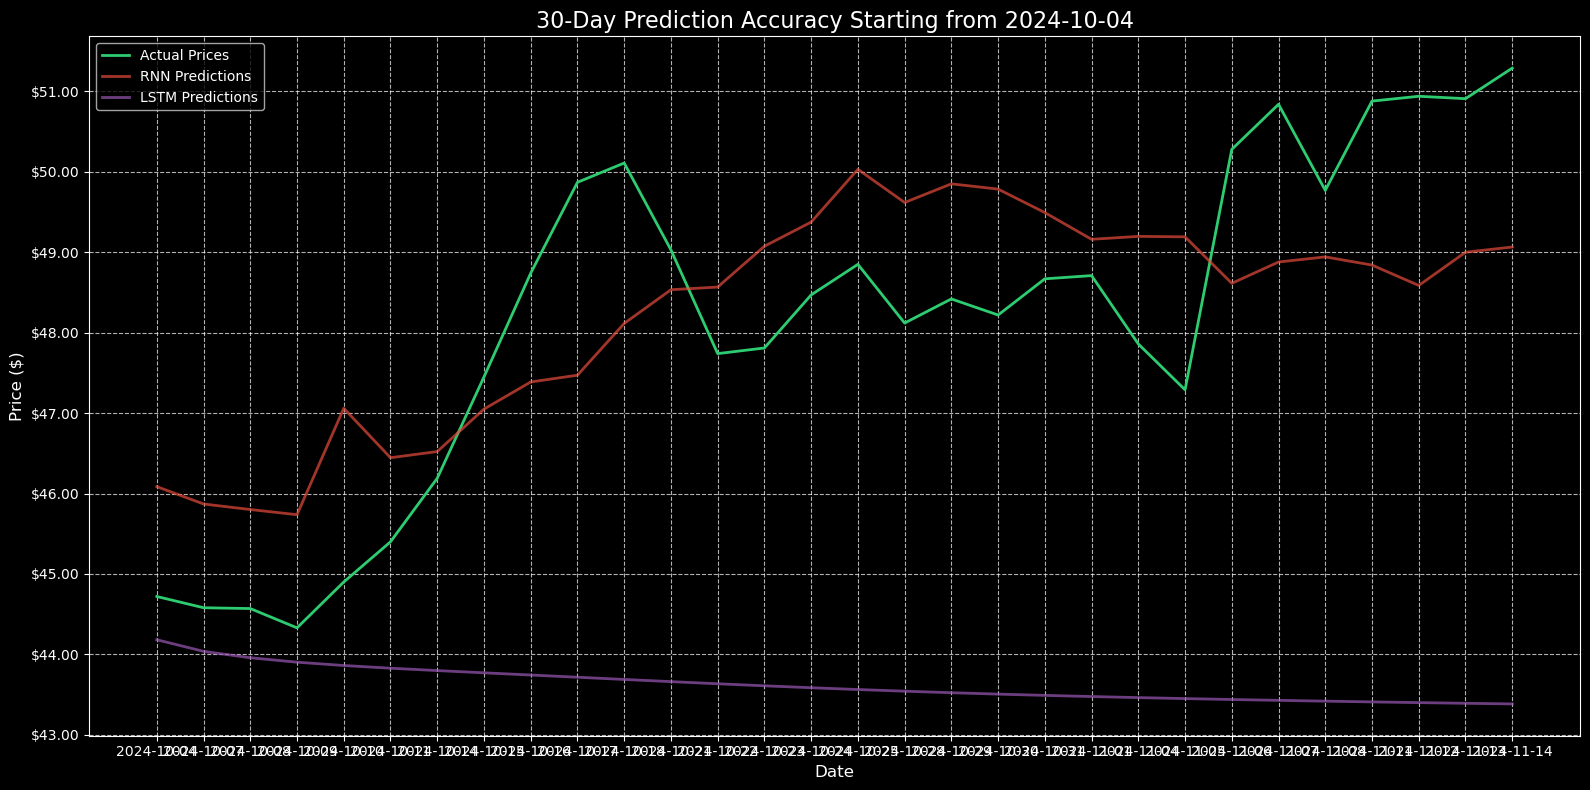


📊 30-Day Prediction Accuracy Evaluation:

SimpleRNN Model:
• Average MSE: 46.58
• Average MAE: 5.40
• Average R²: -33.3894
• Average Direction Accuracy: 50.34%

LSTM Model:
• Average MSE: 19.18
• Average MAE: 3.48
• Average R²: -5.5579
• Average Direction Accuracy: 43.45%


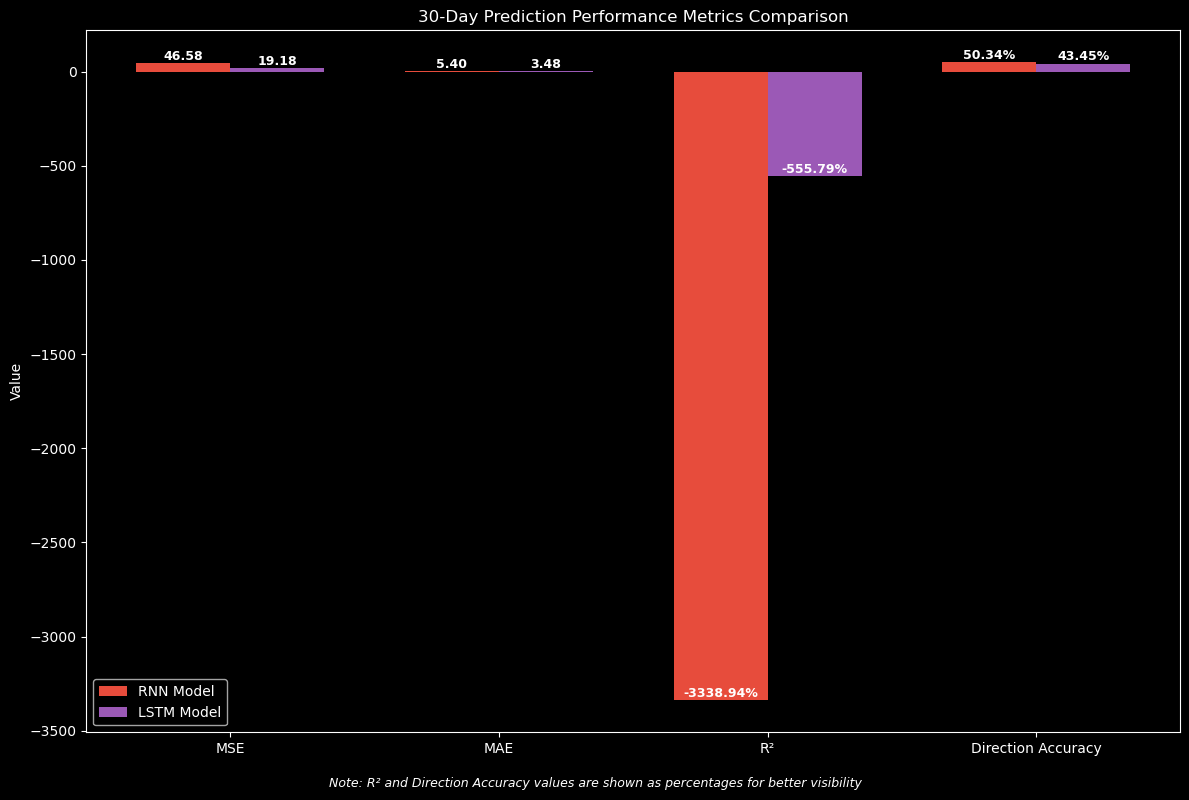

In [24]:
# Example usage:
evaluation_results = evaluate_multi_day_predictions(rnn_model, lstm_model, data, scaler, prediction_length=30)

In [25]:
# # Example of fine-tuning with new data (commented out as it requires new data)

# # Assuming new_data is a DataFrame with 'Date' and 'Open' columns for the next 50 days
# new_data = pd.read_csv("//path/to/new_data.csv")
# new_data['Date'] = pd.to_datetime(new_data['Date'])

# # Fine-tune models
# rnn_model_tuned, lstm_model_tuned, rnn_history_tuned, lstm_history_tuned = fine_tune_models(
#     rnn_model, lstm_model, new_data, time_step=time_step, epochs=10
# )

In [26]:
# # Make prediction after fine-tuning
# future_pred_tuned = predict_future(rnn_model_tuned, lstm_model_tuned, 
#                                   pd.concat([data, new_data]), scaler)

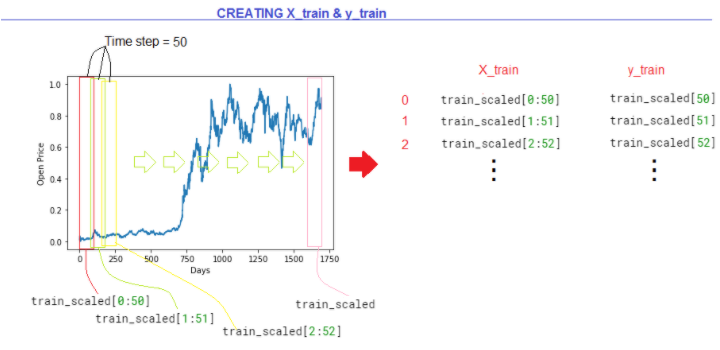

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data